<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import qtensor as qtn
import quimb.tensor, quimb
import cotengra

from cartesian_explorer import Explorer
import cartesian_explorer.caches as caches


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
ex = Explorer()

In [7]:
@ex.provider
def bethe_graph(p, degree=3):
    def add_two_nodes_to_leafs(graph):
        """ Works in-place """
        leaves = [n for n in graph.nodes() if graph.degree(n) <= degree-2]
        n = graph.number_of_nodes()
        for leaf in leaves:
            next_edges = [(leaf, n+x) for x in range(1, degree)]
            graph.add_edges_from(next_edges)
            n += 2
    graph = nx.Graph()
    graph.add_edges_from([(0,1)])
    for i in range(p):
        add_two_nodes_to_leafs(graph)
    print('bethe lattice nodes', graph.number_of_nodes())
    return graph


In [8]:
def quimb_opt(opt_type, **kwargs):
    if opt_type == 'hyper':
        optimizer = cotengra.HyperOptimizer(
            parallel=False,
            max_repeats=10000,
            max_time=kwargs.get('optimizer_time', 1)
        )
    elif opt_type == 'uniform':
        optimizer = cotengra.UniformOptimizer(
            parallel=False,
            methods=['greedy'],
            max_repeats=1_000_000,
            max_time=kwargs.get('optimizer_time', 1)
        )
    else:
        raise ValueError('Ordering algorithm not supported')
    return optimizer
    
@ex.provider
def quimb_tw(bethe_graph, p=2, qmb_opt_time=1, qmb_ordering='uniform'):
    graph = bethe_graph
    terms = {(i,j):1 for i,j in graph.edges}
    gammas, betas = [0.1]*p, [.3]*p
    circ = quimb.tensor.circ_qaoa(terms, p, gammas, betas)

    ZZ = quimb.pauli('Z') & quimb.pauli('Z')
    #return circ.local_expectation(ZZ, edge, optimize=optimizer)
    optimizer = quimb_opt(qmb_ordering, optimizer_time=qmb_opt_time)
    edge = (0, 1)
    rehs = circ.local_expectation_rehearse(ZZ, edge, optimize=optimizer)
    W = np.log2(float(rehs['info'].largest_intermediate))
    return W

In [9]:
ex.get_variable('quimb_tw', p=4)

bethe lattice nodes 62


10.0

In [14]:
@ex.provider
def bethe_lightcone_circuit(bethe_graph, p, composer_type='cone'):
    if composer_type=='cone':
        Composer = qtn.QtreeQAOAComposer
    elif composer_type=='cylinder':
        Composer = qtn.OldQtreeQAOAComposer
    beta, gamma = [0.1]*p, [0.3]*p
    
    print('beta, gamma', beta, gamma, 'type', composer_type)
    comp = Composer(bethe_graph, gamma=gamma, beta=beta)
    comp.energy_expectation_lightcone((0, 1))
    print('len', len(comp.circuit))
    return tuple(comp.circuit)

@ex.provider
def qtensor_tw(bethe_lightcone_circuit, qtn_ordering_algo='default'):
    circuit = bethe_lightcone_circuit
    tn = qtn.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)
    opt = qtn.toolbox.get_ordering_algo(qtn_ordering_algo)
    try:
        peo, _ = opt.optimize(tn)
    except Exception as e:
        print("error", e)
        return None
    return opt.treewidth

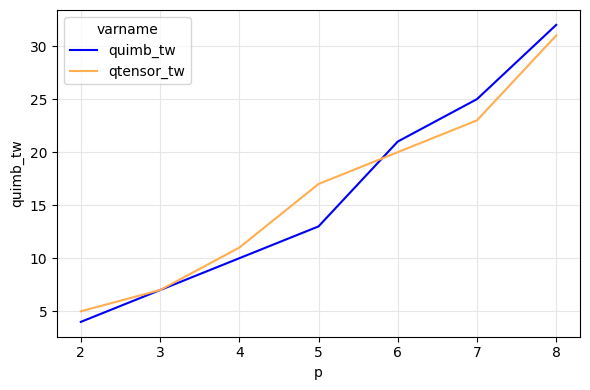

In [19]:
ps = [2, 3, 4, 5, 6, 7, 8]
f = ex.plot_variables(('quimb_tw', 'qtensor_tw'),
                  qtn_ordering_algo=['rgreedy_0.02_20'],
                  qmb_opt_time=[90],
                  qmb_ordering=['hyper'],
                  p=ps
                 )